# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import pyspark
from pyspark.sql import functions as SF
import pyspark.sql.types as pst
from pyspark.sql import Window
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType, DoubleType, StringType, DateType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
import operator
from datetime import datetime as dt
import datetime
from sklearn.feature_extraction import DictVectorizer
from collections import Counter, OrderedDict

pandas.options.display.max_columns = None
pandas.options.display.max_rows = None

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

I guess in the local mode there is no need to set some of the configs, however I am using the same config as if we were running spark in yarn mode.

In [3]:
# create a Spark session
spark = pyspark.sql.SparkSession.builder.appName("sparkify_ms").enableHiveSupport().\
config("spark.executor.instances","5").config("spark.executor.memory","10g").\
config("spark.executor.cores","7").config("spark.driver.cores","7").\
config("spark.driver.memory","20g").config("spark.driver.maxResultSize","18g").getOrCreate()

sc = spark.sparkContext

print(spark.version, sc.master)

2.4.3 local[*]


In [4]:
# sc.stop()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Load json to spark dataframe
df = spark.read.json('mini_sparkify_event_data.json')
type(df)

pyspark.sql.dataframe.DataFrame

In [5]:
# Check data-types
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Data Preview 
pdf = df.limit(100).toPandas()
pdf.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
# Prepare a filturing function
def filter_values(data, spark_functions, col_apply_on, values, isin=True):
    """
    :param data :type Spark datafram
    :param spark_functions: type spark_functions:
    :param col_apply_on :type str - column name for filtering implementation
    :param values :type list - of values within col_apply_on
    :param isin :type bool - True: implement isin(select values), False: implement ~isin(filter values)
    :return: spark dataframe
    """
    if isin:
        return data.where(spark_functions.col(col_apply_on).isin(values))
    else:
        return data.where(~spark_functions.col(col_apply_on).isin(values))

In [7]:
# Check volume & missing id values
print(df.count())
df = df.fillna('', subset=['sessionId', 'userId'])
print(filter_values(df, SF, 'sessionId', '', isin=False).count())
print(filter_values(df, SF, 'userId', '', isin=False).count())

286500
286500
278154


In [8]:
# CLEANING STEPS: drop unwanted columns, drop rows where userId value is missing ...
df = df.drop(*['artist','song','id_copy','firstName', 'lastName'])             
df = df.dropna(how = 'any', subset = ['userId'])
df = filter_values(df, SF, 'userId', '', isin=False)
df = df.withColumn('userId', df['userId'].cast(IntegerType()))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [9]:
# Create churn column
df = df.withColumn('churn', SF.when(SF.col('page') == 'Cancellation Confirmation', 1).otherwise(0))
df.groupBy("churn").count().orderBy('count').sort(SF.desc("count")).show()

+-----+------+
|churn| count|
+-----+------+
|    0|278102|
|    1|    52|
+-----+------+



In [10]:
# Spread the churn value to all rows of "churn" users
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("churn", SF.sum("churn").over(window))

df.groupBy("churn").count().orderBy('count').sort(SF.desc("count")).show()

+-----+------+
|churn| count|
+-----+------+
|    0|233290|
|    1| 44864|
+-----+------+



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Preview values in some of the columns: 
Obviously one of the most interesting columns is the 'page' - will be a source of many usefull features.

In [12]:
print(df.groupBy("userId").count().count(), '\n')
df.groupBy("auth").count().orderBy('count').sort(SF.desc("count")).show(10)
df.groupBy("method").count().orderBy('count').sort(SF.desc("count")).show(10)
df.groupBy("level").count().orderBy('count').sort(SF.desc("count")).show(10)
df.groupBy("page").count().orderBy('count').sort(SF.desc("count")).show(23)

225 

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+

+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



#### With a help of regexTokenizer extract userAgent words - these details can be transformed into a valuable features


In [11]:
df = df.withColumn('userAgent_reg', SF.lower(SF.regexp_replace('userAgent', "[^0-9a-zA-Z\\s]", "")))
regexTokenizer = RegexTokenizer(inputCol="userAgent_reg", outputCol="userAgent_words")
df = regexTokenizer.transform(df)
print(df.groupBy("userAgent_words").count().count())
df.groupBy("userAgent_words").count().orderBy('count').sort(SF.desc("count")).show(10, False)

56
+-------------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent_words                                                                                                                |count|
+-------------------------------------------------------------------------------------------------------------------------------+-----+
|[mozilla50, windows, nt, 61, wow64, applewebkit53736, khtml, like, gecko, chrome3601985143, safari53736]                       |22751|
|[mozilla50, macintosh, intel, mac, os, x, 1094, applewebkit537774, khtml, like, gecko, version705, safari537774]               |19611|
|[mozilla50, macintosh, intel, mac, os, x, 1094, applewebkit53736, khtml, like, gecko, chrome3601985125, safari53736]           |18448|
|[mozilla50, macintosh, intel, mac, os, x, 1094, applewebkit53736, khtml, like, gecko, chrome3601985143, safari53736]           |17348|
|[mozilla50, windows, nt, 61, wow64, rv310, g

##### Words Correlation heatmap
In the heatmap below - created out of the word-matrix (from userAgent word) - we can see that some of the words are perfectly correlated with other ones (yellow dots). We'll need to remove some words accordingly  - as we do not want to have perfectly correlated features in the training df.

(56, 90)


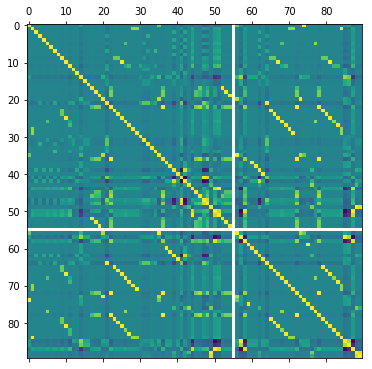

In [22]:
words_list = df.select('userAgent_words').distinct().rdd.map(lambda r: r[0]).collect()

v = DictVectorizer()
X = v.fit_transform(Counter(f) for f in (_l for _l in words_list))
print(X.shape)
words_df = pandas.DataFrame(X.toarray())
words_df.columns = words_df.columns.map(dict([(val, key) for key, val in v.vocabulary_.items()]))
f = plt.figure(figsize=(8, 6))
plt.matshow(words_df.corr(), fignum=f.number)
plt.show()

#### In the next steps let's create some date columns which will help us with research and/or with new features: 
- "temp_" & "hlp_" prefixes are used for temporary or helping columns
- "fe_" prefix will be used strictly for features to train the model on.

In [13]:
# Convert timestamp to date
d_fromtmstp = SF.udf(lambda x: dt.fromtimestamp(x/1000).date(), DateType())
df = df.withColumn("hlp_date", d_fromtmstp(SF.col('ts')))

In [14]:
# Get MIN & MAX date for each user
df = df.withColumn("hlp_date_max", SF.max("hlp_date").over(Window.partitionBy("userId")))
df = df.withColumn("hlp_date_min", SF.min("hlp_date").over(Window.partitionBy("userId")))

In [15]:
# Total days per user
timeFmt = "yyyy-MM-dd"
df = df.withColumn('fe_total_days', SF.datediff(SF.to_date('hlp_date_max', timeFmt), SF.to_date('hlp_date_min', timeFmt)))

#### Check the mean of days customers are using the page   - people who cancelled vs others
 This is a tricky feature, as the numbers in first table may change by time. 
 However the second table tells us which day could be critical and so this feature could help our model too ...

In [18]:
df.filter(df.churn!=1).select(['fe_total_days']).describe().show()
df.filter(df.churn==1).select(['fe_total_days']).describe().show()

+-------+-----------------+
|summary|    fe_total_days|
+-------+-----------------+
|  count|           233290|
|   mean| 55.1186163144584|
| stddev|8.205739140611385|
|    min|                0|
|    max|               61|
+-------+-----------------+

+-------+------------------+
|summary|     fe_total_days|
+-------+------------------+
|  count|             44864|
|   mean| 31.61329796718973|
| stddev|14.225996568464927|
|    min|                 0|
|    max|                58|
+-------+------------------+



#### Increase / Decrease of songs played daily by user per quarters - can we use it as a feature?

This is an experiment with a categorical feature which represents how number of played songs by user increases or decreases from quarter to quarter. 
Let's say we have 20 days of sessions for a user. These 20 days are divided into quarters and we calculate a mean of played songs for each quarter. Than Q1:5, Q2:10, Q3:7, Q4:3 is converted to a value IDD (increase, decrease, decrease). 

In [16]:
join_col = 'temp_join_key'
df = df.withColumn(join_col, SF.concat(SF.col('userId'),SF.lit('_'), SF.col('hlp_date')))
temp_df = df.groupby(join_col).agg(SF.count(SF.when(SF.col('page')=='NextSong', True)).alias('hlp_songs_daily'))

df_churn = df.filter(df.churn==1)
df_churn = df_churn.join(temp_df, 'temp_join_key', how='left')

temp_df = df_churn.dropDuplicates(subset=['temp_join_key'])\
.withColumn('temp_inc_dec', SF.collect_list('hlp_songs_daily').over(Window.partitionBy('userId').orderBy('hlp_date')))
temp_df = temp_df.orderBy(SF.desc('ts')).dropDuplicates(subset=['userId']).select(['userId', 'temp_inc_dec'])
df_churn = df_churn.join(temp_df, 'userId', how='left')

def increase_decrease(_list):
    arrs = np.array_split(_list, 4)
    quarters = [arrs[1].mean() - arrs[0].mean(), 
                arrs[2].mean() - arrs[1].mean(), 
                arrs[3].mean() - arrs[2].mean()]
    def _repl(x):
        if x < 0: return 'D'
        else: return 'I'
    return ''.join([_repl(x) for x in quarters])

increase_decrease_udf = SF.udf(increase_decrease, StringType())
df_churn = df_churn.withColumn("fe_songs_daily_inc_dec", increase_decrease_udf(df_churn['temp_inc_dec']))

In [20]:
df_churn.select('fe_songs_daily_inc_dec').distinct().rdd.map(lambda r: r[0]).collect()

['DID', 'IDI', 'IID', 'III', 'DII', 'IDD', 'DDI']

In [21]:
df_churn.dropDuplicates(subset=['userId']).groupBy("fe_songs_daily_inc_dec").count().orderBy('count')
.sort(SF.desc("count")).show(10)

+----------------------+-----+
|fe_songs_daily_inc_dec|count|
+----------------------+-----+
|                   III|   12|
|                   DII|   10|
|                   IDI|    9|
|                   IDD|    7|
|                   IID|    6|
|                   DID|    5|
|                   DDI|    3|
+----------------------+-----+



Even though I expected to have more D's at the end of the triplets for churn customers, I will use this feature for modeling.

# Feature Engineering
In following step I will create couple of basic features (total counts or averages) and couple of experimental features.

#### total sessions per user

In [17]:
temp_df = df.groupby('userId').agg(SF.count('userId').alias('fe_sessions_total'))
df = df.join(temp_df, 'userId', how='left')

#### FE level switch count
'fe_level_switch_count' feature tells us how many times user switched from PAID to FREE or vice versa

In [18]:
df = df.withColumn("hlp_level", SF.collect_set("level").over(Window.partitionBy("userId", "hlp_date").orderBy(["ts"])))

udf_paid_count = SF.udf(lambda x: int(len(set(x))>1), IntegerType())
df = df.withColumn('fe_hlp_level', udf_paid_count('hlp_level'))

temp_df = df.select('userId', 'hlp_date', 'fe_hlp_level').filter(df.fe_hlp_level==1).groupby('userId', 'hlp_date').agg(SF.max('hlp_date'))
temp_df = temp_df.drop(*['hlp_date', 'max(hlp_date)']).groupby('userId').agg(SF.count('userId').alias('fe_level_switch_count')).drop('fe_hlp_level')
df = df.join(temp_df, 'userId', how='left')

#### FE error & help count per user

In [19]:
# Error
temp_df = df.groupby('userId').agg(SF.count(SF.when(SF.col('page')=='Error', True)).alias('fe_error'))
df = df.join(temp_df, 'userId', how='left')

# Help
temp_df = df.groupby('userId').agg(SF.count(SF.when(SF.col('page')=='Help', True)).alias('fe_help'))
df = df.join(temp_df, 'userId', how='left')

#### Avg Session length

In [20]:
df = df.withColumn("fe_session_len", SF.avg("length").over(Window.partitionBy("userId").orderBy(["ts"])))

#### Songs played daily

In [21]:
# df = df.withColumn("fe_songs_daily", SF.count("length").over(Window.partitionBy("userId", "hlp_date").orderBy(["ts"])))
# join_col = 'temp_join_key'
# df = df.withColumn(join_col, SF.concat(SF.col('userId'),SF.lit('_'), SF.col('hlp_date')))
# temp_df = df.groupby(join_col).agg(SF.count(SF.when(SF.col('page')=='NextSong', True)).alias('fe_songs_daily'))
# df = df.join(temp_df, 'temp_join_key', how='left').drop(join_col)

#### Total Songs played by user

In [22]:
temp_df = df.groupby('userId').agg(SF.count(SF.when(SF.col('page')=='NextSong', True)).alias('fe_songs_total'))
df = df.join(temp_df, 'userId', how='left')

#### Total Songs / Total Days ratio

In [23]:
df = df.withColumn('fe_days_songs_ratio', SF.col('fe_total_days')/SF.col('fe_songs_total'))

#### Total sessions / Total days ratio

In [24]:
df = df.withColumn('fe_sessions_total', SF.col('fe_total_days')/SF.col('fe_songs_total'))

#### Location State
Extracting state abbreviations from location details

In [25]:
def extract_state(loc_col):
    try:
        return str(loc_col).split(',')[-1].strip()
    except:
        return ''
udf_extract_state = SF.udf(extract_state, StringType())
df = df.withColumn('fe_state', udf_extract_state('location'))

#### Tunes played daily - increase/decrease by quarters

Based on the experiment from the the research part I created a function which can be easily used not only for songs played increase/decrease but also for Error or Thumbs Down page:

In [26]:
def page_inc_dec_quarterly_FE(df, page, new_feature_name):
    """ Returns the quarter increase/decrease categories
        for a selected page per user.
    param: df, type: spark dataframe
    param: page, type: string
    param: new_feature_name, type: string
    return: spark dataframe
    """
    
    # Count the daily usage of selected page per user (temp_page_daily)
    join_col = 'temp_join_key'
    df = df.withColumn(join_col, SF.concat(SF.col('userId'),SF.lit('_'), SF.col('hlp_date')))
    temp_df = df.groupby(join_col).agg(SF.count(SF.when(SF.col('page')==page, True)).alias('temp_page_daily'))
    df = df.join(temp_df, 'temp_join_key', how='left')
    
    # Collect the temp_page_daily numbers into lists
    temp_df = df.dropDuplicates(subset=['temp_join_key'])\
    .withColumn('temp_inc_dec', SF.collect_list('temp_page_daily').over(Window.partitionBy('userId').orderBy('hlp_date')))
    
    # Get the major temp_page_daily list - the one from last day & join with df
    temp_df = temp_df.orderBy(SF.desc('ts')).dropDuplicates(subset=['userId']).select(['userId', 'temp_inc_dec'])
    df = df.join(temp_df, 'userId', how='left').drop('temp_page_daily')
    
    def increase_decrease(_list):
        """Splits the list into 4 ongoing parts, 
            calculates the mean and identifies
            increase or decrease between these quarters.
            Returns values like DDI, DID, III, etc ..."""
        arrs = np.array_split(_list, 4)
        quarters = [arrs[1].mean() - arrs[0].mean(), 
                    arrs[2].mean() - arrs[1].mean(), 
                    arrs[3].mean() - arrs[2].mean()]
        def _repl(x):
            if x < 0: return 'D'
            else: return 'I'
        return ''.join([_repl(x) for x in quarters])
    
    # Turn the lists of numbers into the Increase/Decrease categories
    increase_decrease_udf = SF.udf(increase_decrease, StringType())
    return df.withColumn(new_feature_name, increase_decrease_udf(df['temp_inc_dec'])).drop('temp_inc_dec')

df = page_inc_dec_quarterly_FE(df, 'NextSong', 'fe_songs_daily_inc_dec')

#### Errors daily - increase/decrease by quarters

In [27]:
df = page_inc_dec_quarterly_FE(df, 'Error', 'fe_error_daily_inc_dec')

#### Thumbs Down daily - increase/decrease by quarters

In [28]:
df = page_inc_dec_quarterly_FE(df, 'Thumbs Down', 'fe_Thumbs_Down_daily_inc_dec')

#### Number of downgrades per user

In [29]:
temp_df = df.groupby('userId').agg(SF.count(SF.when(SF.col('page')=='Submit Downgrade', True))
                                   .alias('fe_downgrades_total'))
df = df.join(temp_df, 'userId', how='left')

#### Add fe_ prefix to existing features (level, gender, status)

In [30]:
as_is_features = ['level', 'gender', 'status']
for col in as_is_features:
    df = df.withColumnRenamed(col, 'fe_{}'.format(col))

In [31]:
# Lets finalize the lazy function runs  - before we start the complicated part of feature engineering
df.cache()

#### FE userAgent
In this part we tokenize the userAgent words, reduce them to not get perfectly correlated features and create a new feature/column which holds the information about the total usage of each word  per user.
Each word represents a system, version or even a hardware used by customer and it can become a good feature when it comes to predict churn.

In [6]:
def regex_tokenize(df):
    """ Creates new field containing the list of words
        returned by RegexTokenizer from 'userAgent' column.
    param: df, type: spark dataframe
    return: spark dataframe
    """
    df = df.withColumn('userAgent_reg', SF.lower(SF.regexp_replace('userAgent', "[^0-9a-zA-Z\\s]", "")))
    regexTokenizer = RegexTokenizer(inputCol="userAgent_reg", outputCol="userAgent_words")
    return regexTokenizer.transform(df)

def intersect(_lists):
    """Returns intersection of multiple lists.
    param: list of lists
    """
    intrs = list(set(words_list[0]).intersection(set(words_list[1])))
    for x in range(2,len(_lists)):
        intrs = list(set(intrs).intersection(set(words_list[x])))
        if not intrs: break
    return intrs

def remove_perf_corr_columns(words_list):
    """Removes words from the Tokenizer output lists
       to get rid of perfectly correlated couples.
    param: list of lists
    return: list of lists
    """
    v = DictVectorizer()
    while True:
        X = v.fit_transform(Counter(f) for f in (_l for _l in words_list))
        words_df = pandas.DataFrame(X.toarray())
        words_df.columns = words_df.columns.map(dict([(value, key) for key, value in v.vocabulary_.items()]))

        df_corr = words_df.corr().stack().reset_index()
        df_corr.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']
        df_corr = df_corr[((df_corr.CORRELATION==1)) & (df_corr.FEATURE_1!=df_corr.FEATURE_2)]
        if df_corr.shape[0] > 0:
            def select_feature(df):
                return str(sorted([df['FEATURE_1'], df['FEATURE_2']]))

            df_corr['Feature_X'] = df_corr.apply(select_feature, axis=1)
            df_corr.drop_duplicates(subset='Feature_X', inplace=True)
            remove_cols = df_corr.FEATURE_1.tolist()
            new_words_list = []
            for l in words_list:
                l = [item for item in l if item not in remove_cols]
                new_words_list.append(l)
            words_list = new_words_list
        else:
            break
    return words_list

def merge_lists(_lists):
    """Merges multiple lists together.
    param: list of lists
    return: list
    """
    result = _lists[0]
    for x in range(1, len(_lists)):
        result.extend(_lists[x])
    return list(set(result))


# df = regex_tokenize(df) - already done in exploration part
words_list = df.select('userAgent_words').distinct().rdd.map(lambda r: r[0]).collect()
words_to_remove = intersect(words_list)
all_words = merge_lists(words_list)
all_words = [item for item in all_words if item not in words_to_remove]

In [7]:
# Finally: Create the columns with summarized usage of certain words
i = 1
for col_name in all_words:
    i += 1
    udf_contains = SF.udf(lambda x: int(col_name in x), IntegerType())
    temp_col = 'temp_ua_{}'.format(col_name) 
    df = df.withColumn(temp_col, udf_contains(df.userAgent_words))
    df = df.withColumn('fe_ua_{}'.format(col_name), SF.sum(temp_col).over(Window.partitionBy('userId')))
    if (i % 3) == 0: df.cache()

#### Save / Load preprocessed dataframe for more efficiency 

In [4]:
# df.write.parquet(os.path.join('{}/'.format(os.path.abspath(os.getcwd())), 'etl_df_output'))

df = spark.read.parquet(os.path.join('{}/etl_df_output'.format(os.path.abspath(os.getcwd()))))

# Modeling
Let's start with the final preprocessing of our dataframe. For this purpose I have combined all the necessary steps into one function.
For modelling we need a dataframe containing 1 row per user. Extracting these rows in the first step of the function will save us a lot of time as every other operation will be applied to reduced dataframe. In the next steps, except for fillna, we extract the bunch of features we plan to use, create the "label" column out of "churn", we convert categorical features to numerical (this is what pyspark.ml classifiers like RandomForest or GradientBoostedTrees are expecting) and finally we split the data into 3 parts: Train, Test & Validation.

In [8]:
def get_cols_containing_null(df):
    """Returns a list of columns containing null values & Na's
    param: df, type: spark dataframe
    return: python list
    """
    check = df.select(*[col for col in df.columns if col.startswith('fe_')])
    check = check.select([SF.count(SF.when(SF.isnan(c) | SF.isnull(c), c)).alias(c) 
                          for (c,c_type) in check.dtypes if c_type not in ('timestamp', 'string', 'date', ' array')])\
    .toPandas().rename(index={0: '_count'}).T.reset_index()
    return check[check._count>0]['index'].values.tolist()

def preprocess_and_split(df, split_ratio=[0.6, 0.4]):
    """ - Keeps 1 row per user
        - fills na's & nulls
        - selects appropriate features
        - Converts categorical to numerical columns
        - splits the dataframe by provided ratio
    param: df, type: spark dataframe
    param: split_ration, type: list (optional)
    return: train, test and validation df (spark dataframes)
    """
    # select 1 row per user
    window = Window.partitionBy('userId').orderBy(SF.col('ts').desc())
    dff = df.withColumn('row',SF.row_number().over(window)).where(SF.col('row')==2).drop('row')
    
    # Fillna
    na_subset = get_cols_containing_null(dff)
    dff = dff.fillna(0, subset=na_subset)
    
    # select only features & label fields
    features = [col for col in df.columns if col.startswith('fe_')]
    dff = dff.select(*features + ['churn'])
    dff = dff.withColumn('label', df['churn'].cast(DoubleType()))
    dff = dff.drop('churn')
    
    # Convert categorical columns to numerical
    str_cols = [f.name for f in dff.schema.fields if isinstance(f.dataType, StringType)]
    for col in str_cols:
        dff = dff.withColumnRenamed(col, '{}_temp'.format(col))
        stringIndexer = StringIndexer(inputCol='{}_temp'.format(col), outputCol=col)
        si_model = stringIndexer.fit(dff)
        dff = si_model.transform(dff).drop('{}_temp'.format(col))
    
    train_df, test_val = dff.randomSplit(split_ratio, seed=42)
    test_val.cache()
    test_df, val_df = test_val.randomSplit(split_ratio)
    return train_df, test_df, val_df

In [9]:
# Check if we have an appropriate sample of "churn" occasions in each of the datasets.

train_df, test_df, val_df = preprocess_and_split(df)
print('Train: {}/{}'.format(train_df.count(), train_df.filter(train_df.label==1).count()))
print('Test: {}/{}'.format(test_df.count(), test_df.filter(test_df.label==1).count()))
print('Validation: {}/{}'.format(val_df.count(), val_df.filter(val_df.label==1).count()))

Train: 134/28
Test: 54/12
Validation: 37/12


Finally we can start with the training!
Here is the sequence of our steps:
    - Create a dictionary with classifiers as the keys and appropriate paramGrids as values
    - Prepare Vectorizer and Scaler for the pipeline 
      (I decided to use RandomForest and GradientBoostedTrees and therefore Scaling is not necessary,
       however we can keep it in the pipeline in case we decide to add LinearRegression too.
       Scaling will not do any damage to the results anyway.)
    - Next we loop over the classifiers and get the best one of each grid by using F1 score metric
      of the MulticlassClassificationEvaluator. 
    - We save the results and models to a dictionary.
    - In the last step we select the best of the best models by comparing the results of each iteration.
    

Why did we use the F1 score as the key metric? 
As we are using a small dataset, we need to use a bit more demanding metric than precision or recall. F-score is calculated from the precision and recall of testing.
Precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. 
Our goal is to predict true positives as accurate as possible while false positive predictions could lead to wasted resources. Therefore the F1 score became our metric.

In [10]:
# paramGrid_gb = ParamGridBuilder()\
#                .addGrid(gb_clf.maxDepth, [7, 15])\
#                .addGrid(gb_clf.maxBins, [20, 40])\
#                .addGrid(gb_clf.maxIter, [10, 20]).build()

# Create a dictionary of classifiers & thir paramGrids
eval_dict = {}
rf_clf = RandomForestClassifier()
gb_clf = GBTClassifier()

paramGrid_rf = ParamGridBuilder() \
                .addGrid(rf_clf.numTrees, [15]) \
                .addGrid(rf_clf.maxDepth, [7, 15]) \
                .build()

paramGrid_gb = ParamGridBuilder()\
               .addGrid(gb_clf.maxDepth, [7, 12])\
               .addGrid(gb_clf.maxBins, [20])\
               .addGrid(gb_clf.maxIter, [6]).build()

classifiers = {rf_clf: paramGrid_rf, gb_clf: paramGrid_gb}

# Prepare vectorizer & scaler for the pipeline
features = [col for col in train_df.columns if col.startswith('fe_')]
assembler = VectorAssembler(inputCols=features, outputCol='features_vect')
minmaxscaler = MinMaxScaler(inputCol="features_vect", outputCol="features")

# Run the CrossValidator for each classifier and its paramGrid
for clf, paramGrid in classifiers.items():
    pipeline =Pipeline(stages=[assembler, minmaxscaler, clf])

    evaluator=MulticlassClassificationEvaluator(metricName="f1")

    cross_val = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=3)
    
    # Evaluate the model and get the F1 score
    model = cross_val.fit(train_df) 
    eval_result = evaluator.evaluate(model.transform(test_df))
    
    # Create a dictionary of models and F1 scores
    eval_dict[model] = eval_result
    print('{}: {}'.format(str(model), eval_result))

# Select the model with highest evaluation score
best_model = max(eval_dict, key=eval_dict.get)

CrossValidatorModel_fa7a9fc7b80b: 0.8740740740740741
CrossValidatorModel_f9aad3c38b3c: 0.9452208835341365


We achieved F1 training score of 0.95 with GradientBoostedTrees.
Let's have a look at the parameters and testing score of the best model:

In [34]:
param_dict = {}
for m, p in zip(best_model.avgMetrics, best_model.getEstimatorParamMaps()):
    param_dict[str(p)] = m
print('Test F1 Score: {}'.format(round(max(best_model.avgMetrics), 2)))
max(param_dict, key=param_dict.get)

Test F1 Score: 0.9


"{Param(parent='GBTClassifier_e498177ccbb8', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 7, Param(parent='GBTClassifier_e498177ccbb8', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='GBTClassifier_e498177ccbb8', name='maxIter', doc='max number of iterations (>= 0).'): 6}"

In [45]:
# model_path = '{}/best_model/'.format(os.path.abspath(os.getcwd()))
# best_model.save(model_path)

We can now validate our best model on the validation dataset.
I've added couple of more details/metrics to get a better picture of how good our model really is.

In [25]:
pred_df = best_model.transform(val_df)

print('Total correct predictions: {} / 37'.format(pred_df.filter(pred_df.label == pred_df.prediction).count()))
print('Churn correct predictions: {} / 12'.format(pred_df.filter((pred_df.label == pred_df.prediction) & 
                                                                 (pred_df.label == 1)).count()))
print('Churn incorrect predictions: {}'.format(pred_df.filter((pred_df.label == 0) & 
                                                              (pred_df.prediction == 1)).count()))

# convert dataframe to rdd to be able to use MulticlassMetrics
prd_rdd = pred_df.select(['label', 'prediction']).rdd
mc_metrics = MulticlassMetrics(prd_rdd)

print('Precision: {}'.format(round(mc_metrics.precision(), 2)))
print('Recall: {}'.format(round(mc_metrics.recall(), 2)))
print('F1-Score: {}'.format(round(mc_metrics.fMeasure(), 2)))
print('Accuracy: {}'.format(round(mc_metrics.accuracy, 2)))

Total correct predictions: 32 / 37
Churn correct predictions: 7 / 12
Churn incorrect predictions: 0
Precision: 0.86
Recall: 0.86
F1-Score: 0.86
Accuracy: 0.86


### We achieved quite a good score! 